In [1]:
from CBD.Core import CBD
from CBD.lib.std import *

class LinearEq(CBD):
    # y=-2(x-9)+1   ==>   crossing at 9.5
    # y=-2(x-3)-5   ==>   crossing at 0.5
    def __init__(self, name, dt=1.0):
        super().__init__(name, [], ['y'])
        
        self.addFixedRateClock("clock", dt)
        self.addBlock(ConstantBlock("m", -2))
        self.addBlock(ConstantBlock("x1", -9))
        self.addBlock(ConstantBlock("y1", 1))
        self.addBlock(AdderBlock("Xsum"))
        self.addBlock(AdderBlock("Ysum"))
        self.addBlock(ProductBlock("mult"))
        
        self.addConnection("clock-clock", "Xsum", output_port_name="time")
        self.addConnection("x1", "Xsum")
        self.addConnection("m", "mult")
        self.addConnection("Xsum", "mult")
        self.addConnection("mult", "Ysum")
        self.addConnection("y1", "Ysum")
        self.addConnection("Ysum", "y")

In [2]:
from pypdevs.DEVS import AtomicDEVS

class PointCollector(AtomicDEVS):
    def __init__(self, name):
        AtomicDEVS.__init__(self, name)
        
        self.state = {
            "data": [],
            "time": 0.0
        }
        
        self.input = self.addInPort("input")
        self.crossing = self.addInPort("crossing")
        
    def extTransition(self, inputs):
        self.state["time"] += self.elapsed
        if self.input in inputs:
            value = inputs[self.input]
            if self.elapsed == 0 and len(self.state["data"]) > 0:
                self.state["data"].pop()  # -- [1]
            self.state["data"].append((self.state["time"], value))
        if self.crossing in inputs:
            print("CROSSING AT", self.state["time"])
        return self.state
    
    @property
    def data_xy(self):  # -- [2]
        data = self.state["data"][:]  # -- [3]
        return [x for x, _ in data], [y for _, y in data]

In [3]:
from CBD.converters.hybrid import CBDRunner
from pypdevs.DEVS import CoupledDEVS

class Equation(CoupledDEVS):
    def __init__(self, name, dt=1.0):
        super().__init__(name)
        self.eq = self.addSubModel(CBDRunner("eq", LinearEq("eq", dt), crossings={
            "y": 8
        }))
        self.coll = self.addSubModel(PointCollector("coll"))
        
        self.connectPorts(self.eq.outputs["y"], self.coll.input)
        self.connectPorts(self.eq.outputs["crossing-y"], self.coll.crossing)

<IPython.core.display.Javascript object>


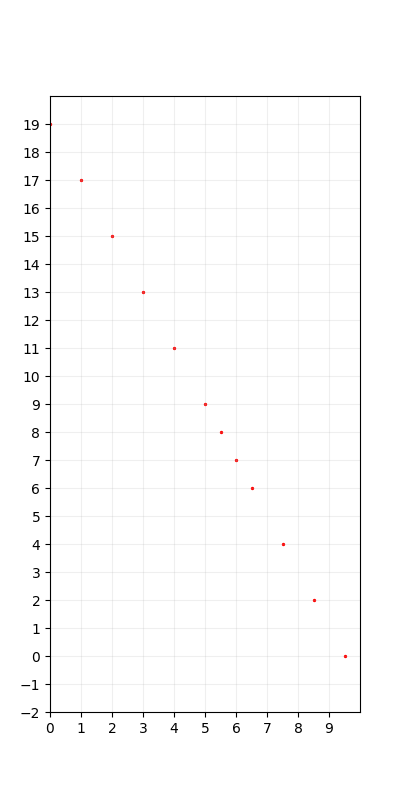

CROSSING AT 5.5


In [4]:
%matplotlib notebook

from CBD.realtime.plotting import PlotManager, ScatterPlot
from pypdevs.simulator import Simulator
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 8))
ax.set_xlim((0, 10))
ax.set_ylim((-2, 20))
ax.set_xticks(range(10))
ax.set_yticks(range(-2, 20))

plt.grid(alpha=0.2)

eq = Equation("eq", 1.0)
sim = Simulator(eq)
sim.setClassicDEVS()
# sim.setRealTime()
# sim.setVerbose()
sim.setTerminationTime(10)

manager = PlotManager()
manager.register("eq", eq.coll, (fig, ax), ScatterPlot(s=2, c='red'))

sim.simulate()

plt.show()